In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.image import imread
import anndata as ad
from scipy.stats import pearsonr

## ST-ConMa

In [ ]:
RESULT_DIR = '../../results/gep_pred/st_conma_igc_igm/heg/her2st'
DATA_DIR = '../../ft_dataset/gep_pred/her2st'

SAMPLE = 'B6'
PATIENT = 'B'
GENE = 'CD24'

# Load pred / true
pred = np.load(f'{RESULT_DIR}/patient_{PATIENT}_samples/{SAMPLE}_pred.npy')
true = np.load(f'{RESULT_DIR}/patient_{PATIENT}_samples/{SAMPLE}_true.npy')

cnt_df = pd.read_csv(f'{DATA_DIR}/ST-cnts-normalized/{SAMPLE}.tsv', sep='\t', index_col=0)
gene_names = cnt_df.columns.tolist()
spot_ids = cnt_df.index.tolist()

# Load spot coordinates and filter to match prediction spots
spot_df = pd.read_csv(f'{DATA_DIR}/ST-spotfiles/{SAMPLE}_selection.tsv', sep='\t')
spot_df['spot_key'] = spot_df['x'].astype(str) + 'x' + spot_df['y'].astype(str)
spot_df = spot_df[spot_df['spot_key'].isin(spot_ids)].reset_index(drop=True)

# Tissue image
img_path = f'{DATA_DIR}/ST-imgs/{PATIENT}/{SAMPLE}/BT10737_E2_HE.jpg'
img = imread(img_path)

print(f'pred: {pred.shape}, true: {true.shape}, genes: {len(gene_names)}, spots: {len(spot_ids)}, spot_df: {spot_df.shape[0]}')
print(f'{GENE} index: {gene_names.index(GENE)}')

/NAS_Storage3/yeomtl/anaconda3/envs/st_conma/lib/python3.10/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92070301 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


pred: (277, 250), true: (277, 250), genes: 250, spots: 277, spot_df: 277
CD24 index: 127


In [ ]:
# Get CD24 values
gene_idx = gene_names.index(GENE)
true_gene = true[:, gene_idx]
pred_gene = pred[:, gene_idx]

adata_true = ad.AnnData(
    X=true_gene.reshape(-1, 1),
    obs=pd.DataFrame({'spot_id': spot_ids}, index=[str(i) for i in range(len(spot_ids))]),
)
adata_true.var_names = [GENE]

adata_pred = ad.AnnData(
    X=pred_gene.reshape(-1, 1),
    obs=pd.DataFrame({'spot_id': spot_ids}, index=[str(i) for i in range(len(spot_ids))]),
)
adata_pred.var_names = [GENE]

# Set spatial coordinates and tissue image
spatial_key = f'{SAMPLE}_image'
for adata in [adata_true, adata_pred]:
    adata.obsm['spatial'] = spot_df[['pixel_x', 'pixel_y']].values
    adata.uns['spatial'] = {
        spatial_key: {
            'images': {'hires': img},
            'scalefactors': {
                'tissue_hires_scalef': 1.0,
                'spot_diameter_fullres': 150.0,
            },
        }
    }

print('AnnData ready:', adata_true.shape, adata_pred.shape)

AnnData ready: (277, 1) (277, 1)


/tmp/ipykernel_2868300/359818191.py:4: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(
/tmp/ipykernel_2868300/359818191.py:10: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


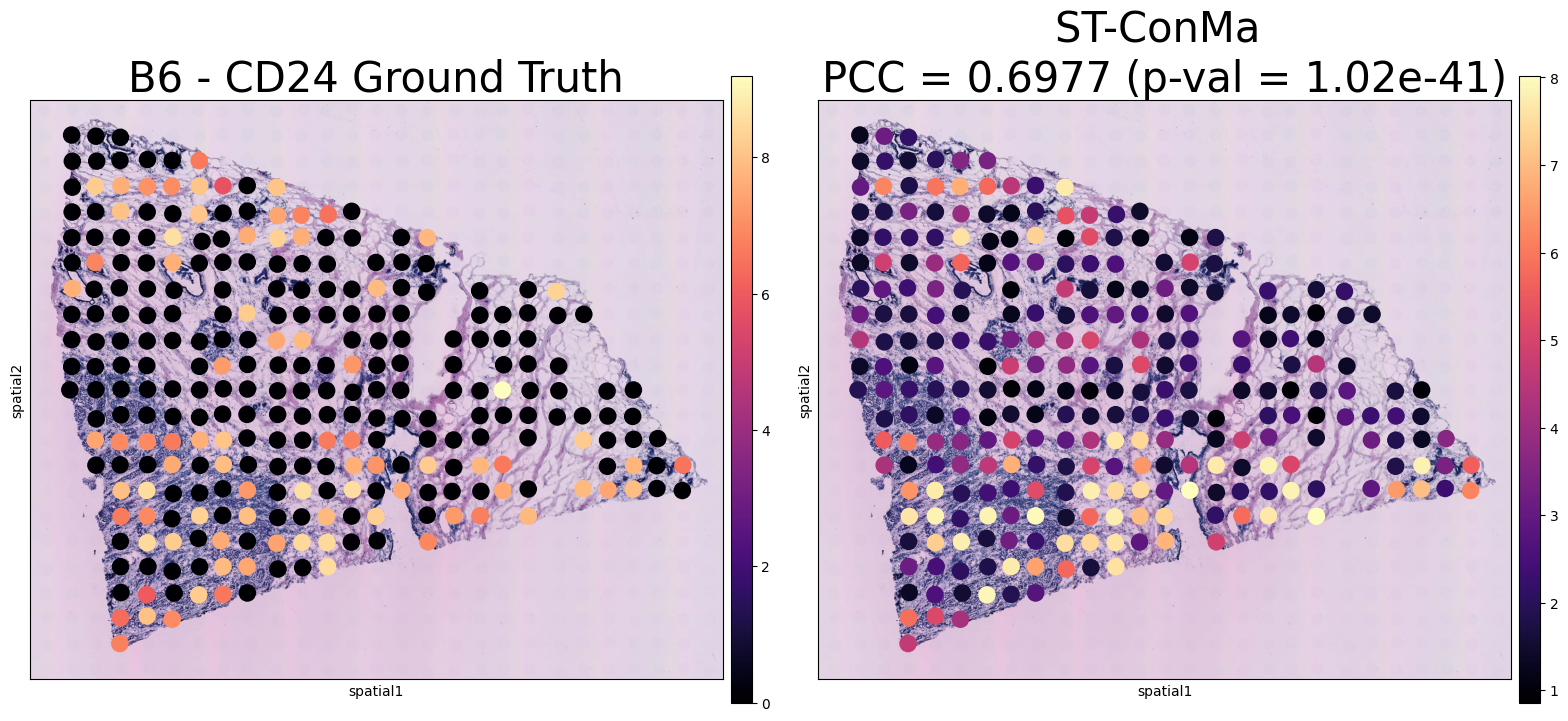

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
pcc, pval = pearsonr(true_gene, pred_gene)

sc.pl.spatial(
    adata_true, color=GENE, library_id=spatial_key,
    img_key='hires', spot_size=200, title=f'{SAMPLE} - {GENE} Ground Truth',
    color_map="magma", show=False, ax=axes[0],
)

sc.pl.spatial(
    adata_pred, color=GENE, library_id=spatial_key,
    img_key='hires', spot_size=200, title=f'ST-ConMa \nPCC = {pcc:.4f} (p-val = {pval:.2e})',
    color_map="magma", show=False, ax=axes[1],
)
# Bigger titles
for ax in axes:
    ax.set_title(ax.get_title(), fontsize=30)


plt.tight_layout()
plt.show()

## ST_ConMa (Zero-shot)

In [ ]:
RESULT_DIR = '../../results/gep_pred/st_conma_zeroshot/heg/her2st'

# Load pred / true
pred = np.load(f'{RESULT_DIR}/patient_{PATIENT}_samples/{SAMPLE}_pred.npy')
true = np.load(f'{RESULT_DIR}/patient_{PATIENT}_samples/{SAMPLE}_true.npy')

In [9]:
# Get CD24 values
gene_idx = gene_names.index(GENE)
true_gene = true[:, gene_idx]
pred_gene = pred[:, gene_idx]

# Build AnnData for ground truth
adata_true = ad.AnnData(
    X=true_gene.reshape(-1, 1),
    obs=pd.DataFrame({'spot_id': spot_ids}, index=[str(i) for i in range(len(spot_ids))]),
)
adata_true.var_names = [GENE]

# Build AnnData for prediction
adata_pred = ad.AnnData(
    X=pred_gene.reshape(-1, 1),
    obs=pd.DataFrame({'spot_id': spot_ids}, index=[str(i) for i in range(len(spot_ids))]),
)
adata_pred.var_names = [GENE]

# Set spatial coordinates and tissue image
spatial_key = f'{SAMPLE}_image'
for adata in [adata_true, adata_pred]:
    adata.obsm['spatial'] = spot_df[['pixel_x', 'pixel_y']].values
    adata.uns['spatial'] = {
        spatial_key: {
            'images': {'hires': img},
            'scalefactors': {
                'tissue_hires_scalef': 1.0,
                'spot_diameter_fullres': 150.0,
            },
        }
    }

print('AnnData ready:', adata_true.shape, adata_pred.shape)

AnnData ready: (277, 1) (277, 1)


/tmp/ipykernel_2868300/702397393.py:4: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(
/tmp/ipykernel_2868300/702397393.py:10: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


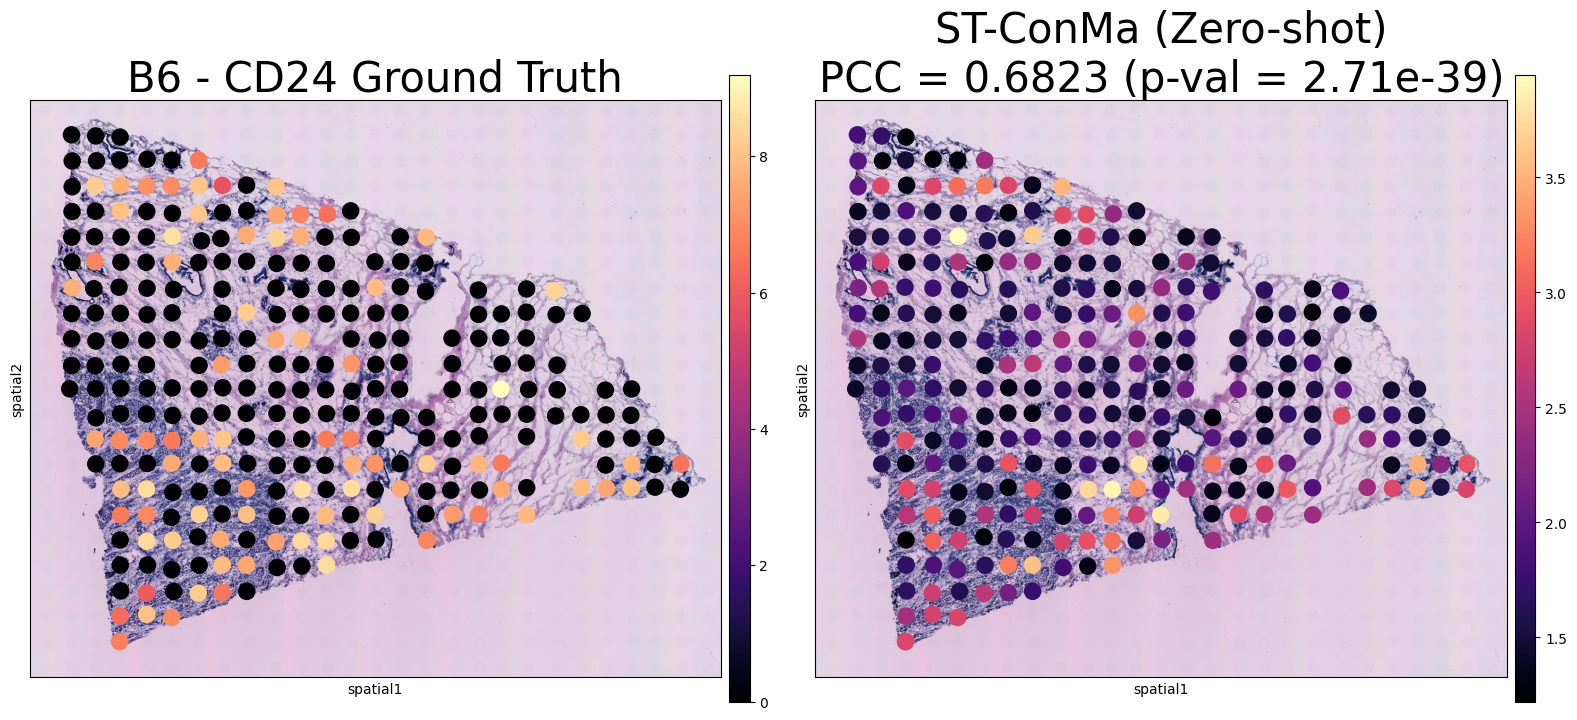

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
pcc, pval = pearsonr(true_gene, pred_gene)

sc.pl.spatial(
    adata_true, color=GENE, library_id=spatial_key,
    img_key='hires', spot_size=200, title=f'{SAMPLE} - {GENE} Ground Truth',
    color_map='magma', show=False, ax=axes[0],
)

sc.pl.spatial(
    adata_pred, color=GENE, library_id=spatial_key,
    img_key='hires', spot_size=200, title=f'ST-ConMa (Zero-shot)\nPCC = {pcc:.4f} (p-val = {pval:.2e})',
    color_map='magma', show=False, ax=axes[1],
)
# Bigger titles
for ax in axes:
    ax.set_title(ax.get_title(), fontsize=30)


plt.tight_layout()
plt.show()